In [2]:
import tsflex
print(tsflex.__version__)

0.2.3


## Get the data

In [3]:
from tsflex.utils.data import load_empatica_data

df_tmp, df_acc, df_gsr, df_ibi = load_empatica_data(["tmp", "acc", "gsr", "ibi"])

In [4]:
from pandas.tseries.frequencies import to_offset

data = [df_tmp, df_acc, df_gsr, df_ibi]
for df in data:
    print("Time-series:", df.columns.values)
    print(df.shape)
    try:
        print("Sampling rate:", 1 / pd.to_timedelta(to_offset(pd.infer_freq(df.index))).total_seconds(), "Hz")
    except:
        print("Irregular sampling rate")
    print()

Time-series: ['TMP']
(30200, 1)
Irregular sampling rate

Time-series: ['ACC_x' 'ACC_y' 'ACC_z']
(241620, 3)
Irregular sampling rate

Time-series: ['EDA']
(30204, 1)
Irregular sampling rate

Time-series: ['IBI']
(1230, 1)
Irregular sampling rate



## Look at the data

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=len(data), cols=1, shared_xaxes=True, 
    subplot_titles=[df.columns.values[0].split('_')[0] for df in data],
    vertical_spacing=0.1,
)

for plot_idx, df in enumerate(data, 1):
    # Select first minute of data
    sub_df = df.first('1min')
    for col in df.columns:
        fig.add_trace(
            go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
            row=plot_idx, col=1
        )

fig.update_layout(height=len(data)*200)

fig.show(renderer='iframe')

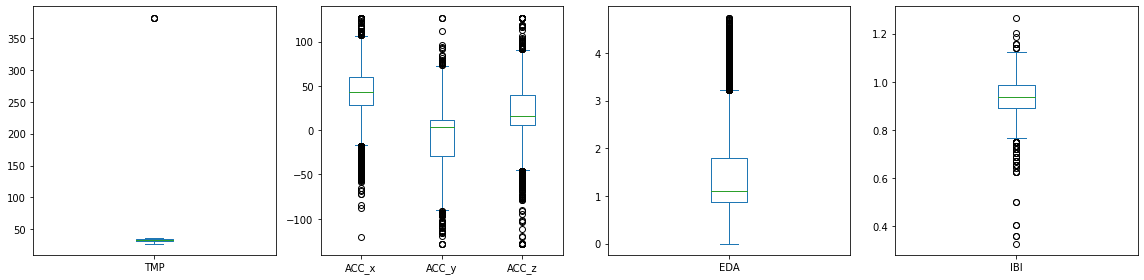

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

These visualizations indicate that some preprocessing might be necessary for the signals (some sort of clipping)

# tsflex processing

This is roughly identical to the processing of [this paper notebook](https://github.com/predict-idlab/tsflex/blob/main/examples/tsflex_paper.ipynb)

In [7]:
import pandas as pd; import numpy as np; from scipy.signal import savgol_filter
from tsflex.processing import SeriesProcessor, SeriesPipeline

# Create the processing functions
def clip_data(sig: pd.Series, min_val=None, max_val=None) -> np.ndarray:
    return np.clip(sig,  a_min=min_val, a_max=max_val)

def smv(*sigs) -> pd.Series:
    sig_prefixes = set(sig.name.split('_')[0] for sig in sigs)
    result = np.sqrt(np.sum([np.square(sig) for sig in sigs], axis=0))
    return pd.Series(result, index=sigs[0].index, name='|'.join(sig_prefixes)+'_'+'SMV')

# Create the series processors (with their keyword arguments)
tmp_clippper = SeriesProcessor(clip_data, series_names="TMP", max_val=35)
acc_savgol = SeriesProcessor(
    savgol_filter, ["ACC_x", "ACC_y", "ACC_z"], window_length=33, polyorder=2
)
acc_smv = SeriesProcessor(smv, ("ACC_x", "ACC_y", "ACC_z"))

# Create the series pipeline & process the data
series_pipe = SeriesPipeline([tmp_clippper, acc_savgol, acc_smv])
series_pipe

[
	clip_data {'max_val': 35} :  ('TMP',)
	savgol_filter {'window_length': 33, 'polyorder': 2} :  ('ACC_x',) ('ACC_y',) ('ACC_z',)
	smv {} :  ('ACC_x', 'ACC_y', 'ACC_z')
]

In [8]:
out_data = series_pipe.process(data, drop_keys=["ACC_x", "ACC_y", "ACC_z"])

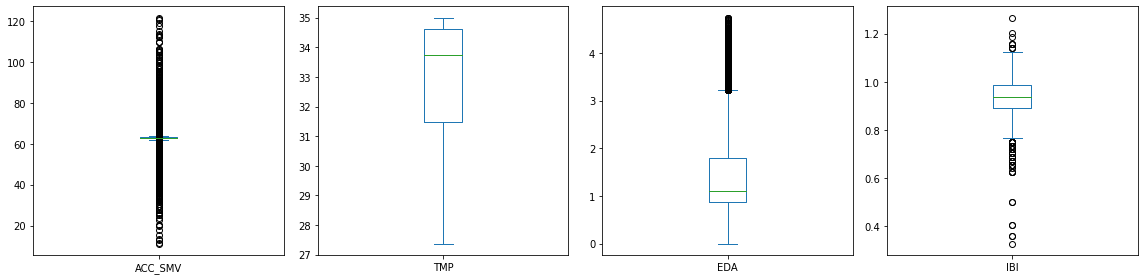

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(out_data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

# tsflex feature extraction with [seglearn](https://github.com/dmbee/seglearn) integration

In [10]:
# !pip install seglearn

> Useful link;  
> [Documentation of all of the seglearn features](https://dmbee.github.io/seglearn/feature_functions.html)

[seglearn feature dictionaries](https://github.com/dmbee/seglearn/blob/master/seglearn/feature_functions.py) is how seglearn represents a collection of features.  
**=> requires wrapping this dictionary in a `seglearn_feature_dict_wrapper` for interoperability with tsflex.**

As [seglearn feature-functions](https://github.com/dmbee/seglearn/blob/master/seglearn/feature_functions.py) are vectorized along the first axis (axis=0), we need to expand our window-data.  
=> convert `1D np.array` to a `2D np.array` with all the window-data in `axis=1`

In [11]:
# This wrapper handles segleran its feature dictionaries
from tsflex.features.integrations import seglearn_feature_dict_wrapper
# This wrapper does exactly that conversion
from tsflex.features.integrations import seglearn_wrapper

In [12]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection

## Using seglearn feature dictionaries

In [13]:
# Import base feature & all feature functions from seg-learn
from seglearn.feature_functions import base_features, all_features

Calculate the features for a seglearn feature dictionary.  
Note that;
* `seglearn_feature_dict_wrapper` transforms this feature extraction settings object to a list of features that you can directly pass as the `function` argument of tsflex `MultipleFeatureDescriptors`.

In [14]:
basic_feats = MultipleFeatureDescriptors(
        functions=seglearn_feature_dict_wrapper(base_features()),
        series_names=["ACC_SMV", "EDA", "TMP"],
        windows=["5min", "2.5min"],
        strides="2min",
    )
feature_collection = FeatureCollection(basic_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__std, ['std'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__var, ['var'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__minimum, ['minimum'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__maximum, ['maximum'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__skew, ['skew'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__kurt, ['kurt'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mse, ['mse'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean_crossings, ['mean_crossings'], {}),
	]
	win: 2m30s , stride: 2m:

In [15]:
features_df = feature_collection.calculate(out_data, return_df=True, show_progress=True)
features_df

  0%|          | 0/66 [00:00<?, ?it/s]

,ACC_SMV__abs_energy__w=2m30s_s=2m,ACC_SMV__abs_energy__w=5m_s=2m,ACC_SMV__kurt__w=2m30s_s=2m,ACC_SMV__kurt__w=5m_s=2m,ACC_SMV__maximum__w=2m30s_s=2m,ACC_SMV__maximum__w=5m_s=2m,ACC_SMV__mean__w=2m30s_s=2m,ACC_SMV__mean__w=5m_s=2m,ACC_SMV__mean_crossings__w=2m30s_s=2m,ACC_SMV__mean_crossings__w=5m_s=2m,...,TMP__minimum__w=2m30s_s=2m,TMP__minimum__w=5m_s=2m,TMP__mse__w=2m30s_s=2m,TMP__mse__w=5m_s=2m,TMP__skew__w=2m30s_s=2m,TMP__skew__w=5m_s=2m,TMP__std__w=2m30s_s=2m,TMP__std__w=5m_s=2m,TMP__var__w=2m30s_s=2m,TMP__var__w=5m_s=2m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,1.908184e+07,NaN,26.491261,NaN,83.457743,NaN,62.975757,NaN,0.0,NaN,...,27.370001,NaN,465024.094373,NaN,7.030135,NaN,0.705593,NaN,0.497862,NaN
2017-06-13 14:26:43+02:00,1.919667e+07,NaN,25.526637,NaN,92.325941,NaN,63.155303,NaN,0.0,NaN,...,28.230000,NaN,504830.393464,NaN,-0.493916,NaN,0.379786,NaN,0.144238,NaN
2017-06-13 14:27:13+02:00,NaN,3.833208e+07,NaN,26.228116,NaN,92.325941,NaN,63.109737,NaN,0.0,...,NaN,27.370001,NaN,9.785186e+05,NaN,1.114036,NaN,0.894276,NaN,0.799730
2017-06-13 14:28:43+02:00,1.900028e+07,NaN,54.005349,NaN,76.211915,NaN,62.903173,NaN,0.0,NaN,...,29.430000,NaN,538692.068494,NaN,-0.271463,NaN,0.361422,NaN,0.130626,NaN
2017-06-13 14:29:13+02:00,NaN,3.821475e+07,NaN,42.807015,NaN,92.325941,NaN,63.044016,NaN,0.0,...,NaN,28.230000,NaN,1.048903e+06,NaN,-0.312452,NaN,0.643985,NaN,0.414717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-13 16:23:13+02:00,NaN,3.815810e+07,NaN,36.011074,NaN,69.608959,NaN,63.042887,NaN,0.0,...,NaN,29.610001,NaN,1.109715e+06,NaN,-0.256389,NaN,0.482924,NaN,0.233215
2017-06-13 16:24:43+02:00,1.910876e+07,NaN,22.102164,NaN,82.316042,NaN,63.051531,NaN,0.0,NaN,...,30.870001,NaN,574609.351628,NaN,0.311723,NaN,0.050810,NaN,0.002582,NaN
2017-06-13 16:25:13+02:00,NaN,3.820289e+07,NaN,32.912284,NaN,82.316042,NaN,63.055640,NaN,0.0,...,NaN,30.270000,NaN,1.141975e+06,NaN,-1.264685,NaN,0.205881,NaN,0.042387


Extract all seglearn features.

In [16]:
all_feats = MultipleFeatureDescriptors(
        functions=seglearn_feature_dict_wrapper(all_features()),
        series_names=["ACC_SMV", "EDA", "TMP"],
        windows=["5min", "2.5min"],
        strides="2min",
    )
feature_collection = FeatureCollection(all_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__gmean, ['gmean'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__hmean, ['hmean'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__vec_sum, ['vec_sum'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__abs_sum, ['abs_sum'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__std, ['std'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__var, ['var'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__median_absolute_deviation, ['median_absolute_deviation'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__variation, ['variatio

In [17]:
features_df = feature_collection.calculate(out_data, return_df=True, show_progress=True)
features_df

  0%|          | 0/168 [00:00<?, ?it/s]

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/scipy/stats/stats.py:283: RuntimeWarning:

divide by zero encountered in log

/users/jonvdrdo/.venvs/venv37/lib/python3.7/site-packages/scipy/stats/stats.py:283: RuntimeWarning:

divide by zero encountered in log



,ACC_SMV__abs_energy__w=2m30s_s=2m,ACC_SMV__abs_energy__w=5m_s=2m,ACC_SMV__abs_sum__w=2m30s_s=2m,ACC_SMV__abs_sum__w=5m_s=2m,ACC_SMV__corr2__w=2m30s_s=2m,ACC_SMV__corr2__w=5m_s=2m,ACC_SMV__emg_var__w=2m30s_s=2m,ACC_SMV__emg_var__w=5m_s=2m,ACC_SMV__gmean__w=2m30s_s=2m,ACC_SMV__gmean__w=5m_s=2m,...,TMP__variation__w=2m30s_s=2m,TMP__variation__w=5m_s=2m,TMP__vec_sum__w=2m30s_s=2m,TMP__vec_sum__w=5m_s=2m,TMP__waveform_length__w=2m30s_s=2m,TMP__waveform_length__w=5m_s=2m,TMP__willison_amplitude__w=2m30s_s=2m,TMP__willison_amplitude__w=5m_s=2m,TMP__zero_crossing__w=2m30s_s=2m,TMP__zero_crossing__w=5m_s=2m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,1.908184e+07,NaN,302283.632453,NaN,0.0,NaN,3976.211801,NaN,62.893977,NaN,...,0.025353,NaN,16698.359375,NaN,9.709995,NaN,599.0,NaN,599.0,NaN
2017-06-13 14:26:43+02:00,1.919667e+07,NaN,303145.455278,NaN,0.0,NaN,4000.138715,NaN,63.077723,NaN,...,0.013094,NaN,17402.480469,NaN,2.139997,NaN,599.0,NaN,599.0,NaN
2017-06-13 14:27:13+02:00,NaN,3.833208e+07,NaN,605853.471250,NaN,0.0,NaN,3993.341344,NaN,63.029913,...,NaN,0.031332,NaN,34250.121094,NaN,11.869993,NaN,1199.0,NaN,1199.0
2017-06-13 14:28:43+02:00,1.900028e+07,NaN,301935.231772,NaN,0.0,NaN,3959.217127,NaN,62.890307,NaN,...,0.012063,NaN,17976.878906,NaN,2.180008,NaN,599.0,NaN,599.0,NaN
2017-06-13 14:29:13+02:00,NaN,3.821475e+07,NaN,605222.550996,NaN,0.0,NaN,3981.117704,NaN,62.998784,...,NaN,0.021787,NaN,35469.523438,NaN,4.400007,NaN,1199.0,NaN,1199.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-13 16:23:13+02:00,NaN,3.815810e+07,NaN,605211.716845,NaN,0.0,NaN,3975.216292,NaN,63.039741,...,NaN,0.015882,NaN,36487.281250,NaN,4.399990,NaN,1199.0,NaN,1199.0
2017-06-13 16:24:43+02:00,1.910876e+07,NaN,302647.348806,NaN,0.0,NaN,3981.821077,NaN,63.007000,NaN,...,0.001642,NaN,18567.839844,NaN,1.899998,NaN,599.0,NaN,599.0,NaN
2017-06-13 16:25:13+02:00,NaN,3.820289e+07,NaN,605334.139491,NaN,0.0,NaN,3979.882530,NaN,63.027519,...,NaN,0.006674,NaN,37017.679688,NaN,4.079985,NaN,1199.0,NaN,1199.0


### Plot the EDA features

In [18]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features'],
    vertical_spacing=0.1
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    if not np.issubdtype(sub_df.values.dtype, np.number):
        continue
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')

## Using basic seglearn features

Wrapping seglearn features individually.

In [19]:
# Import base feature functions from seg-learn
from seglearn.feature_functions import base_features

basic_feats = MultipleFeatureDescriptors(
        functions=[seglearn_wrapper(f, f_name) for f_name, f in base_features().items()],
        series_names=["ACC_SMV", "EDA", "TMP"],
        windows=["5min", "2.5min"],
        strides="2min",
    )
feature_collection = FeatureCollection(basic_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__std, ['std'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__var, ['var'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__minimum, ['min'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__maximum, ['max'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__skew, ['skew'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__kurt, ['kurt'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mse, ['mse'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean_crossings, ['mnx'], {}),
	]
	win: 2m30s , stride: 2m: [
		FeatureDescrip

In [20]:
features_df = feature_collection.calculate(out_data, return_df=True)
features_df

,ACC_SMV__abs_energy__w=2m30s_s=2m,ACC_SMV__abs_energy__w=5m_s=2m,ACC_SMV__kurt__w=2m30s_s=2m,ACC_SMV__kurt__w=5m_s=2m,ACC_SMV__max__w=2m30s_s=2m,ACC_SMV__max__w=5m_s=2m,ACC_SMV__mean__w=2m30s_s=2m,ACC_SMV__mean__w=5m_s=2m,ACC_SMV__median__w=2m30s_s=2m,ACC_SMV__median__w=5m_s=2m,...,TMP__mnx__w=2m30s_s=2m,TMP__mnx__w=5m_s=2m,TMP__mse__w=2m30s_s=2m,TMP__mse__w=5m_s=2m,TMP__skew__w=2m30s_s=2m,TMP__skew__w=5m_s=2m,TMP__std__w=2m30s_s=2m,TMP__std__w=5m_s=2m,TMP__var__w=2m30s_s=2m,TMP__var__w=5m_s=2m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,1.908184e+07,NaN,26.491261,NaN,83.457743,NaN,62.975757,NaN,63.199194,NaN,...,0.0,NaN,465024.094373,NaN,7.030135,NaN,0.705593,NaN,0.497862,NaN
2017-06-13 14:26:43+02:00,1.919667e+07,NaN,25.526637,NaN,92.325941,NaN,63.155303,NaN,62.775194,NaN,...,0.0,NaN,504830.393464,NaN,-0.493916,NaN,0.379786,NaN,0.144238,NaN
2017-06-13 14:27:13+02:00,NaN,3.833208e+07,NaN,26.228116,NaN,92.325941,NaN,63.109737,NaN,63.092027,...,NaN,0.0,NaN,9.785186e+05,NaN,1.114036,NaN,0.894276,NaN,0.799730
2017-06-13 14:28:43+02:00,1.900028e+07,NaN,54.005349,NaN,76.211915,NaN,62.903173,NaN,62.931577,NaN,...,0.0,NaN,538692.068494,NaN,-0.271463,NaN,0.361422,NaN,0.130626,NaN
2017-06-13 14:29:13+02:00,NaN,3.821475e+07,NaN,42.807015,NaN,92.325941,NaN,63.044016,NaN,62.901436,...,NaN,0.0,NaN,1.048903e+06,NaN,-0.312452,NaN,0.643985,NaN,0.414717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-13 16:23:13+02:00,NaN,3.815810e+07,NaN,36.011074,NaN,69.608959,NaN,63.042887,NaN,62.953852,...,NaN,0.0,NaN,1.109715e+06,NaN,-0.256389,NaN,0.482924,NaN,0.233215
2017-06-13 16:24:43+02:00,1.910876e+07,NaN,22.102164,NaN,82.316042,NaN,63.051531,NaN,63.079077,NaN,...,0.0,NaN,574609.351628,NaN,0.311723,NaN,0.050810,NaN,0.002582,NaN
2017-06-13 16:25:13+02:00,NaN,3.820289e+07,NaN,32.912284,NaN,82.316042,NaN,63.055640,NaN,63.041110,...,NaN,0.0,NaN,1.141975e+06,NaN,-1.264685,NaN,0.205881,NaN,0.042387


### Plot the EDA features

In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features'],
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')